<img src="https://raw.githubusercontent.com/DuYicong515/15688_final_project/master/image/github-logo.png"/>
# **Introduction**
Github is the friend of every programmer. It is the world's biggest open-sourced code hosting platform that allows you to share and collaborate your code with programmers around the world.


Founded in 2008, Github has grown really fast. The number of newly joined users and newly created repositories increase dramatically every year. Now, it has more than 30 million users and 40 million repositories. 

What are these repositories about? Where are these users from? Could we learn about the latest trend of software development from Github? Inspired by these questions, we implement this project, to give an insight look into Github in the view of data science.

# **Content**



In this notebook, we will cover the following topics:

- [Data Collection](#Data-Collection)
- [Data Processing](#Data-Processing)
- [Visualization and Analysis](#Visualization-and-Analysis)
- [A Deeper Look: Recommending Collaborators](#A-Deeper-Look:-Recommending-Collaborators)
- [References](#References)
- [Appendix](#Appendix)

# **Data Collection**

To solve the problems we curiou about, we should first collect the data we need. The data collection section of our project could be divided into two parts:

- Collect data from github search api

  From gitbub search api, we collection the data of **Top repositories** (with more than 500 stars), **Top users** (with more than 100 followers), and the the total number of users and repositories of each year. 
  
  The data from the api is neat and clean, which facilitate our work. However, it has strict read limitaions, so we use Google BigQuery when collecting bigger dataset.  
 
- Collect data using Google BigQuery
  
  We use Google BigQuery to deal with global data. That is, to query through all the data in github. For example, we collect the use of language of all users in github, to find out the language with the most users. 

<span style="color:red">Important Note:</span>
**Our codes in data collection session below could not be run directly in Jupyter Notebook because the data set requires a lot of time to collect online and is too big to load offline. If you are intersted in the details of our data, please see references at the end of the notebook for more information.**

## Collect data from Github search api
To solve the problems we curios about, we should first collect the data we need. The data collection section of our project could be divided into two parts:

- Collect data from github search api

  From gitbub search api, we collection the data of **Top repositories** (with more than 500 stars) and **Top users** (with more than 100 followers).
  
  The data from the api is neat and clean, which facilitate our work. However, it has strict read limitaions, so we use Google BigQuery when collecting bigger dataset. 
 
- Collect data using Google BigQuery
  
  We use Google BigQuery to deal with global data. That is, to query through all the data in github. For example, we collect the nationality of each user in github, to find out the countries with the most users. 
  
### Collect infomation about hot repositories
The github search api documentation can be founded [here](https://developer.github.com/v3/). We'll show a small code snippet to introduce how can we use the search API and what kind of information does it provides for searching repos. The example is about searching for repositories whose stars are over 500.  We won't involve the repos that are forked from others. The result will be showed in a descend order by star number.

In [3]:
import requests

In [10]:
base_repo_search = 'https://api.github.com/search/repositories?'
query_repo_500stars = base_repo_search + '&q=stars%3A>%3D500o=desc&s=stars&fork=false'
#adding this header will return infos about the topics that the repo focuesd on
headers = {'Accept':'application/vnd.github.mercy-preview+json'}
r = requests.get(query_repo_8500stars,headers = headers)
data = r.json()
print("Response keys for search repo")
print(list(data.keys()))
print ("Total number of repos whose stars are more than 500: ")
print(data['total_count'])
print("Infomation we could get from search repo")
print(list(data['items'][0].keys()))

Response keys for search repo
['total_count', 'incomplete_results', 'items']
Total number of repos whose stars are more than 500: 
29249
Infomation we could get from search repo
['id', 'name', 'full_name', 'owner', 'private', 'html_url', 'description', 'fork', 'url', 'forks_url', 'keys_url', 'collaborators_url', 'teams_url', 'hooks_url', 'issue_events_url', 'events_url', 'assignees_url', 'branches_url', 'tags_url', 'blobs_url', 'git_tags_url', 'git_refs_url', 'trees_url', 'statuses_url', 'languages_url', 'stargazers_url', 'contributors_url', 'subscribers_url', 'subscription_url', 'commits_url', 'git_commits_url', 'comments_url', 'issue_comment_url', 'contents_url', 'compare_url', 'merges_url', 'archive_url', 'downloads_url', 'issues_url', 'pulls_url', 'milestones_url', 'notifications_url', 'labels_url', 'releases_url', 'deployments_url', 'created_at', 'updated_at', 'pushed_at', 'git_url', 'ssh_url', 'clone_url', 'svn_url', 'homepage', 'size', 'stargazers_count', 'watchers_count', 'lang

For large number of queries, we need to use authentication when we query the data.
The rate limit is quite strict when you try to get data from Github Search API.
For authenticated user, only top 1000 search results are returned with number of result per page being 100. One page of information is returned per request, and the rate limit 5000 requests per hour. 
As a result, we have to set a reasonable range for search each time to avoid losing information.

We are going to scarpe all info about the repos with more than 500 stars and save the results in json files. Include your Github username and password for authentication. The detail code can be found at [Appendix](#Collect-hot-repositories-data)

### Collect infomation about top users
Now we'll show a code snippet to show how to collect info from top users whose followers are over 100. It is similar to collecting hot repo information. However, we'll query detail information use the legacy search as it contains data like location, number of repos, etc. Legacy search api could be found [here](https://developer.github.com/v3/search/legacy/)


In [9]:
base_user_search = 'https://api.github.com/search/users?'
query_user_100followers = base_user_search + '&q=followers%3A>%3D100&o=desc&s=followers&fork=false'
r = requests.get(query_user_100followers)
data = r.json()
print ("Total number of users whose followers are more than 100: ")
print(data['total_count'])

Total number of users whose followers are more than 100: 
23472


In [15]:
query_user_100followers = 'https://api.github.com/legacy/user/search/followers%3A>%3D100'
r = requests.get(query_user_100followers)
data = r.json()
print("infomation we could get from legacy search api")
print(list(data['users'][0].keys()))

infomation we could get from legacy search api
['name', 'login', 'repos', 'id', 'created_at', 'username', 'followers', 'gravatar_id', 'location', 'type', 'followers_count', 'fullname', 'created', 'language', 'score', 'public_repo_count']


Again, due to the read limitaion, we need to set range for our search to avoid information lost.

Then, we're going to scarpe the information about the users with more than 100 followers. The result is saved in json files, include the location, the created time, the number of followers and the programming language of the top users.
The detailed code for scarping data is attached in the [Appendix](#Collect-top-users-data).

The total data we get from hot repos and users are 149.9 MB and 9.5 MB respectively.

## Collect infomation using Google BigQuery
BigQuery is a data warehouse and analytics platform that allow users to analyze public datasets using SQL queries. 

Here we ude the public Github dataset on BigQuerry. It is a 3TB+ dataset contains the summarized information of over 2.8 million open source Github repositories. The dataset including five sheets:
```
    Commits;  Files;  Contents;  Languages;  Liscenses;
```
We use SQL queries to collect the data we want and analyze it, then store the result in csv files. A simple SQL that searches for users with CMU domain email looks like below.
```
SELECT
  COUNT(committer.email)
FROM
  [bigquery-public-data:github_repos.commits]
WHERE
  committer.email CONTAINS 'cmu.edu'
```
Search for the language usage in all repos is as follow.
```
SELECT
  language.name, count(repo_name) as num
FROM
  [bigquery-public-data:github_repos.languages]
group by language.name
```

## Collect infomation about growth across the year
To better understand the trend of users and repositories in Github, we collect the total number of users and repositories of in Github each year from 2008 to now.

In [5]:
import pandas as pd
import glob
import json
import numpy as np
import collections
from collections import Counter

In [23]:
def query_repo_user(base_query, year, auth, repo = True):
    if repo:
        query = base_query + 'repositories?'
    else:
        query = base_query + 'users?'
    query = query + 'q=created%3A{}-01-01..{}-12-31'.format(str(year),str(year))
    
    r = requests.get(query,auth = auth)
    return r.json()['total_count']

In [24]:
years = list(range(2008,2019))
year_stat_frame = pd.DataFrame(columns=['year','repos','users'])

In [ ]:
for i,year in enumerate(years):
    repos = query_repo_user(base_query, year, auth)
    users = query_repo_user(base_query, year, auth, repo = False)
    #commits = query_commit(base_query,year,auth)
    year_stat_frame.loc[i] = [year,repos,users]
    time.sleep(10)

The collected data is going to save in csv file for later processing

In [ ]:
year_stat_frame.to_csv('statistics.csv')

# Data Processing
Now, we're going to process the data we get from last section to get the information we want.

For the **Hot repositories** data, we load what we stored in JSON into pandas, and then selected the columns related to our analysis in the next section.

For the **Top users** data, we load the data from JSON into a dictionary with the listed keys:
```
    "location",
    "created_at",
    "followers_count",
    "language",
    "repos"
```

Each keys followed with a list. We clean the location data to get the nationality of the users using Google api.

For the numbers of users and repositories of in Github each year
, we load the number into a dataframe.


Fist we save all the repository data into pandas DataFrame. The topics covered by the repos are going to save in a list.

In [6]:
import pandas as pd
import glob
import json
import numpy as np
import collections

In [11]:
filenames = list(reversed(glob.glob("repos/*.json")))
columns = ['stargazers_count', 'forks_count','id', 'name', 
           'created_at', 'full_name', 'language', 'updated_at','topics']
frame_columns = columns[:8]
repos_frame = pd.DataFrame(columns=frame_columns)
topics = []

In [12]:
order = 0
for filename in filenames:
    with open(filename) as f:
        repo_file = json.load(f)
        repos = repo_file['items']
        for repo in repos:
            values = []
            for col in columns:
                if col == "topics":
                    topics.extend(repo[col])
                else:
                    values.append(repo[col])
            repos_frame.loc[order] = values
            order += 1

In [14]:
print(repos_frame.head())

  stargazers_count forks_count        id                               name  \
0              554          93  52872057  RecyclerViewWithHeaderNewPractice   
1              554         263  19357036               spark-scala-tutorial   
2              553          69  32246828                       markdownlint   
3              553         187  75743317                        RNPolymerPo   
4              553         630   2323906                  Repetier-Firmware   

             created_at                                  full_name  \
0  2016-03-01T11:30:58Z  drakeet/RecyclerViewWithHeaderNewPractice   
1  2014-05-01T20:33:48Z           deanwampler/spark-scala-tutorial   
2  2015-03-15T05:37:49Z                    DavidAnson/markdownlint   
3  2016-12-06T15:15:52Z                       yanbober/RNPolymerPo   
4  2011-09-04T16:20:49Z                 repetier/Repetier-Firmware   

           language            updated_at  
0              Java  2018-05-01T05:03:11Z  
1  Jupyter Noteb

We then load all top user's data to dictionary.

In [15]:
user_info_dict = collections.defaultdict(list)
columns_user = ["location","created_at","followers_count","created","language","repos"]
filenames_users = glob.glob("users_l/*.json")

In [16]:
for filename in filenames_users:
    with open(filename) as f:
        user_file = json.load(f)
        users = user_file['users']
        for user in users:
            for col in columns_user:
                if user[col] is not None:
                    user_info_dict[col].append(user[col])

The total number of newly created users and repo of each year is loaded into pandas dataframe. The dataframe is showed using plotly

In [7]:
import plotly
plotly.tools.set_credentials_file(username=PLOTLY_USER_NAME, api_key=PLOTLY_API_KEY)
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff

In [8]:
year_statistics_df = pd.read_csv("statistics.csv")
py.iplot(ff.create_table(year_statistics_df), filename='new create on github by year')

## Get country information from the users

The location info is filled out by the user. As a result, there's no standard format and it's hard to know the country that the location belonging to without processing. Let's see the original format of the user's location.

In [48]:
print(user_info_dict['location'][:10])

['Toronto / Canada', 'Auckland NZ', 'Cologne, Germany', 'Denver, CO', 'Louisville, Kentucky', 'Austria', 'Sao Paulo, Brazil', 'Vancouver, BC', 'Manila, Philippines', 'Switzerland']


Google Map has provided us with an API that could be used to query the belonging country of a place. A code snippet is showed below. 

In [50]:
import googlemaps
place = "Auckland NZ"
maps = googlemaps.Client(key=GOOGLE_API_KEY)

In [55]:
_result = gmaps.geocode(place)
components_list = _result[0]['address_components']
for e in components_list:
    if 'country' in e['types']:
        country = (e['long_name'])
print(country)

New Zealand


According to the API rate limit, we query location for the belonging once a second. The detailed code can be found in the [Appendix](#Get-user's-country-info-from-geoencoding).

We then save the results into a JSON file.

# Visualization and Analysis
Fiinally we come to the excited moment of visualizing and analyzing our data! Let's go and tour around Github!
## Global View

### It's time to Github!
#### Focus
Github is a young comminity founded in 2008. However, it expands in an exploding speed and has become the largest community of open soure developwes in the world. What has happened? To understand this,  we plot out the trend of users and repositories during these ten years.

In [9]:
years = year_statistics_df['year'].tolist()[:10]
repos = year_statistics_df['repos'].tolist()[:10]
users = year_statistics_df['users'].tolist()[:10]

scatter_trace1 = go.Scatter(x = years, y=users ,name = "users", mode = 'lines+markers',
                            line = dict(width = 4), marker = dict(color = "rgb(60,180,203)"))
scatter_trace2 = go.Scatter(x = years, y=repos, name = "repos",mode = "lines+markers",
                            line = dict(width = 4), marker = dict(color = "rgb(243,163,42)"))

scatter_data = [scatter_trace1,scatter_trace2]

py.iplot(scatter_data, filename = "New Create on Github by Year")

#### Analysis
We could see that both the number of users and repositories keep growing consecutively, especially after 2014. We believe that this shows the prosperity of computer science and software development.

### What Languages are Popular?
#### Focus
We all get the common view that English is the "World Language" nowadays, but what is the most popular programming language? Do the programming language which has the most users also has the most exciting repositories? Why is it popular?

In [17]:
repo_language_usage = Counter(repos_frame['language'].tolist())
user_language_usage = Counter(user_info_dict['language'])

In [18]:
import copy
top_language_counter = copy.deepcopy(repo_language_usage)
for key,val in user_language_usage.items():
    top_language_counter[key] += val
top_language = top_language_counter.most_common()
language = []
repo_language_count = []
user_language_count = []
for key,val in top_language:
    language.append(key)
    user_language_count.append(user_language_usage[key])
    repo_language_count.append(repo_language_usage[key])
    if(len(language) == 15):
        break

In [19]:
bar_trace1 = go.Bar(x = language[:15], y = repo_language_count[:15],name = "Hot Repos",
                    marker = dict(color = "rgb(243,163,42)"))
bar_trace2 = go.Bar(x = language[:15], y = user_language_count[:15],name = "Top Users",
                    marker = dict(color = "rgb(60,180,203)"))

layout = go.Layout(
    title='Use of language',
    yaxis=dict(title='count'),
    barmode='group',
    bargap=0.05,
    bargroupgap=0.1)

fig = go.Figure(data=[bar_trace1,bar_trace2], layout=layout)

py.iplot(fig,filename = "bar_chart")

#### Analysis
JavaScript is the absolute winner in this competition. Python and Java also enjoy wide popularity.

However, since these datas are collected among top users and hot repositories, there may be a different situation among all users in Github. So we collect the language usage of all the users in Github using Google Google BigQuery, and take a further look.


In [20]:
###total language usage from google big query
language_all_df = pd.read_csv("language_all.csv")
print(language_all_df.head())
language_all_dict = dict(zip(language_all_df.language_name, language_all_df.num))

  language_name      num
0     Batchfile    98841
1           CSS   827355
2          HTML   788428
3          Java   372734
4    JavaScript  1113318


In [21]:
##count all languages
language_all_count = [language_all_dict[lan] for lan in language if lan is not None]

In [22]:
with open('countries.json', 'r') as f:
    countries = json.load(f)
country_counter = Counter(countries)

In [23]:
trace = go.Scatter(
    x = repo_language_count,
    y = language_all_count,
    text = language,
    mode = 'markers+text',
    textposition = 'bottom',
    marker = dict(
        color = 'rgb(60,180,203)'
    )
)
layout = go.Layout(
    title='Use of language',
    xaxis=dict(title='usage in hot repos'),
    yaxis=dict(title='usage in all repos'),
    barmode='group',
    bargap=0.05,
    bargroupgap=0.1)
data = [trace]
# Plot and embed in ipython notebook!
py.iplot(data,layout = layout)

#### Analysis
The x-axis is the number of people using the language among top users, while y-axis is that among all github users. We could observe that: 
- JavaScript is still the champion
- Go and Objective-C is widely used among top users, but not that poppular in all users. This may infer that the requirement of engineers using these languages will grow in recent years.
- HTML, C# and CSS is widey used among all users, but few top users choose them. So we may came to an arbitrary conclusion that it may become out of style.

### Where are the top Users?
#### Focus
As the "World Village" of programmers, the world's best prorammers gathered in Github. Where are them from? Who is the country that has the most excellent programmers? 
To plot top user's location distribution among countries, we need to convert country name to country code.

In [24]:
import pycountry
hot_users_country_df = pd.DataFrame(columns=['country','code','count'])
index = 0
for key,value in country_counter.items():
    try:
        country_code = pycountry.countries.get(name=key).alpha_3
        hot_users_country_df.loc[index] = [key,country_code,value]
        index+=1
    except:
        continue
print(hot_users_country_df.head())

        country code count
0        Jersey  JEY     1
1        Turkey  TUR   166
2         Ghana  GHA     4
3       Germany  DEU   866
4  Saudi Arabia  SAU     4


In [25]:
data = dict(
        type='choropleth',
        colorscale = [[0.0, 'rgb(242,240,247)'],[0.0125, 'rgb(218,218,235)'],[0.025, 'rgb(188,189,220)'],\
            [0.05, 'rgb(158,154,200)'],[0.1, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']],
        locations = hot_users_country_df['code'],
        z = hot_users_country_df['count'].astype(float),
        text = hot_users_country_df['country'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "popular user number")
        )

layout = dict(
        title = 'Popular users around the world',
        geo = dict(
            projection=dict( type='Mercator'),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )

In [26]:
fig = dict(data=[data], layout=layout)
py.iplot(fig, filename='Hot Users Count')

#### Analysis

The USA is the country where most top users build their career. China, Britain and German also has lots of talents.

To view in continents, North American and Asia lead the competition.

### How to Become a Top Github-er?
#### Focus
If you want to become the king of Facebook, you need at leas 120 million fans just like *Cristiano Ronaldo*. If you want to be the instagramm queens, *Selena Gomez* with 140 million followers could be your goal. But is it the same thing in Github?

In [27]:
data = [go.Histogram(x=user_info_dict['followers_count'],
                     histnorm='probability')]
layout = go.Layout(
    title='hot user follower distribution',
    bargap=0.2,
    bargroupgap=0.1,
    xaxis=dict(
        range=[0, 2000]
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

#### Analysis

Surprisingly, most top users only has 100-200 followers. So start today, you may find it is much easier to become a  top user in Github than you think!

## Hot Repositories

### Be a fashioned Github-er!
#### Focus
What are the topics of the hottest repositories in Github?

In [28]:
topics = list(filter(lambda e: e != None, topics))
language = list(filter(lambda e: e != None, language))
language_set = set(list(map(lambda e: e.lower(), language)))
topic_list = list(filter(lambda e: e.lower() not in language_set, topics))
hot_topic_pair = Counter(topic_list).most_common(20)
hot_topic = [x[0] for x in hot_topic_pair]
hot_topic_count = [x[1] for x in hot_topic_pair]

In [29]:
data = [go.Bar(x=hot_topic, y=hot_topic_count,marker = dict(color = "rgb(243,163,42)"))]
layout = go.Layout(yaxis=dict(title='count'))
py.iplot(data, filename='basic-bar')

#### Analysis
Mobile development(andriod and ios), frontend framework(react, vue, react-native), backend framework (golang, docker) and machine learning(machine-learning, deep-learning) are most commonly covered in the hot repositories. The high rank of go language here support our conclusion that it will become a hot topic widely in recent years.

### When are hot repos created?
#### Focus
Do you know when are hot repos created? Mostly on weekends or weekdays? At summer or winter? We take a look at the create time of those hot repositories to find an answer. 

In [30]:
from datetime import datetime
create_time = repos_frame['created_at'].tolist()
create_year_pair= Counter(list(map(lambda e: datetime.strptime(e, '%Y-%m-%dT%H:%M:%SZ').year, create_time))).most_common()
create_year_pair.sort(key = lambda x:x[0])
create_year = [x[0] for x in create_year_pair]
create_year_count = [x[1] for x in create_year_pair]

In [31]:
create_month_pair= Counter(list(map(lambda e: datetime.strptime(e, '%Y-%m-%dT%H:%M:%SZ').month, create_time))).most_common()
create_month_pair.sort(key = lambda x:x[0])
create_month = [x[0] for x in create_month_pair]
create_month_count = [x[1] for x in create_month_pair]

In [32]:
create_day_pair= Counter(list(map(lambda e: datetime.strptime(e, '%Y-%m-%dT%H:%M:%SZ').weekday(), create_time))).most_common()
create_day_pair.sort(key = lambda x:x[0])
create_day_count = [x[1] for x in create_month_pair]

In [33]:
trace1 = go.Bar(x=create_year, y=create_year_count,marker = dict(color = "rgb(243,163,42)"),name = "year count")
trace2 = go.Bar(x=create_month, y=create_month_count,marker = dict(color = "rgb(60,180,203)"),name = "month count")
trace3 = go.Bar(x=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'],
                y=create_day_count,marker = dict(color = "rgb(130,191,110)"),name = "weekday count")

fig = plotly.tools.make_subplots(rows=3, cols=1, subplot_titles=('Create Year', 'Create Month',
                                                          'Create Day'))

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 2, 1)
fig.append_trace(trace3, 3, 1)

py.iplot(fig, filename='create time')

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x2,y2 ]
[ (3,1) x3,y3 ]



#### Analysis
Surprise! The top developers in Github is so perseverant that they start their repositories no matter workdays or weekends, summer or winter! I guess we just lose an excuse of being lazy.
Also, we notice that most hot repositories is created in 2015, which is break out year for technology.

### The Key to Be Hot!
#### Focus
What is the key to become a hot repository? Be curious about that, we check the updating frequency of the hot repositories.

In [34]:
update_time = repos_frame['updated_at'].tolist()
recent_update_days = list(map(lambda e: (datetime.now()-datetime.strptime(e, '%Y-%m-%dT%H:%M:%SZ')).days-3,update_time))
update_days_count = Counter(recent_update_days).most_common()
update_days_count.sort(key = lambda x:x[0])

In [35]:
ns = [1,3,5,10,30,90]
update_day = [0]
proportion = []
total_repos = len(update_time)
for n in ns:
    less_than_n_days = list(map(lambda e: e[1] if e[0] < n else 0, update_days_count))
    update_day.append(np.sum(less_than_n_days) - sum(update_day))
    proportion.append(np.sum(less_than_n_days)/total_repos)
update_day.append(total_repos - sum(update_day))

In [36]:
# last_update = 
# data = [go.Bar(x=last_update, y=update_day[1:],marker = dict(color = "rgb(243,163,42)"))]
# layout = go.Layout(xaxis=dict(title='recent update time'),yaxis=dict(title='count'))
# py.iplot(data, filename='recent-update')

labels = ['in 1 day','in 3 day','in 5 day','in 10 day','in 30 day','in 90 day','more']
values = update_day[1:]

trace = go.Pie(labels=labels, values=values,hoverinfo='label+percent', textinfo='value')

py.iplot([trace], filename='recent-update')

#### Analysis
We found that popular repos updates really frequently.  More than half of them have a push in less than a day. Over 70% of hot repos update in 3 days.  Only 1 percent has its last update 10 days ago.
Wanna be a hot repository? Update!

## Github Around You

### Github in universities
#### Focus
Is Github Hot in university? Which university has most Github commits? We scarpe data from Google BigQuery to search for commits with author-email has a specific school domain to illustrate the result.

In [37]:
##read csv from Google BigQuery result, uniname, email domain, commitcount
uni_user_df = pd.read_csv("university.csv")

In [38]:
##get geo location for each school
uni_user_df['lat'] = 0.0
uni_user_df['lng'] = 0.0

In [41]:
for index, row in uni_user_df.iterrows():
    _result = gmaps.geocode(row['uni_name'])
    uni_user_df.at[index, 'lat'] = x = _result[0]['geometry']['location']['lat']
    uni_user_df.at[index, 'lng'] = _result[0]['geometry']['location']['lng']

In [42]:
print(uni_user_df.head())

mapbox_access_token = 'pk.eyJ1Ijoic2lqaWFjaGVuIiwiYSI6ImNqYXlmczByMzZmcnYzM3J6Mml1OHBzOWIifQ.0H_Dhky9gz79nTDqIckWPA'

site_lat = uni_user_df['lat']
site_lon = uni_user_df['lng']
site_color = uni_user_df['count']
locations_name = uni_user_df['uni_name']

print(len(site_lon), len(site_lat))

trace =  go.Scattermapbox(
        lat=site_lat,
        lon=site_lon,
        mode='markers',
        marker=dict(
            size=17,
            color= site_color,
            opacity=0.7,
            colorscale='RdBu',
            showscale=True
        ),
        text=locations_name,
        hoverinfo='text'
    )

layout = go.Layout(
    title='Nuclear Waste Sites on Campus',
    autosize=True,
    hovermode='closest',
    showlegend=False,
    mapbox=dict(
        accesstoken=mapbox_access_token,
        bearing=0,
        center=dict(
            lat=38,
            lon=-94
        ),
        pitch=0,
        zoom=3,
        style='light'
    ),
)

fig = dict(data=[trace], layout=layout)
py.iplot(fig, filename='University User')

                     uni_name        domain   count        lat         lng
0  Carnegie Mellon University       cmu.edu  121544  40.442808  -79.943013
1                         MIT       mit.edu  402970  42.360091  -71.094160
2                    Berkeley  berkeley.edu  218796  37.871593 -122.272747
3                    Stanford  stanford.edu  220344  37.427475 -122.169719
4                        UIUC      uiuc.edu   34456  40.101952  -88.227161
10 10


#### Analysis
Aha, Github is very popular among top CS schools in US.Although many people work or study at college don't use a school email, most school we search for has a total commit over 100,000. And...MIT has the most commit info with their school email.
### Github in Pittsburgh
#### Focus
Github is around you! Who is the user with the most follower in Pittsburgh? What's their most commonly used language? Let data tell you the result!

In [43]:
##get top 10 user's name and photo_url in Pittsburgh
r = requests.get("https://api.github.com/search/users?q=location%3Apittsburgh&type=Users&o=desc&s=followers")
names = []
image_url = []
for user in r.json()['items']:
    names.append(user['login'])
    image_url.append(user['avatar_url'])
    if len(names) == 10:
        break

In [44]:
##get detailed information about hot user in Pittsburgh and save in dataframe
columns = ["followers_count","username","language","repos","avatar_url"]
pitts_users_frame = pd.DataFrame(columns=columns)
for i,name in enumerate(names):
    r = requests.get("https://api.github.com/legacy/user/search/{}".format(name))
    vals = []
    for column in columns:
        if column != 'avatar_url':
            vals.append(r.json()["users"][0][column])
    vals.append(image_url[i])
    pitts_users_frame.loc[i] = vals
    time.sleep(1)

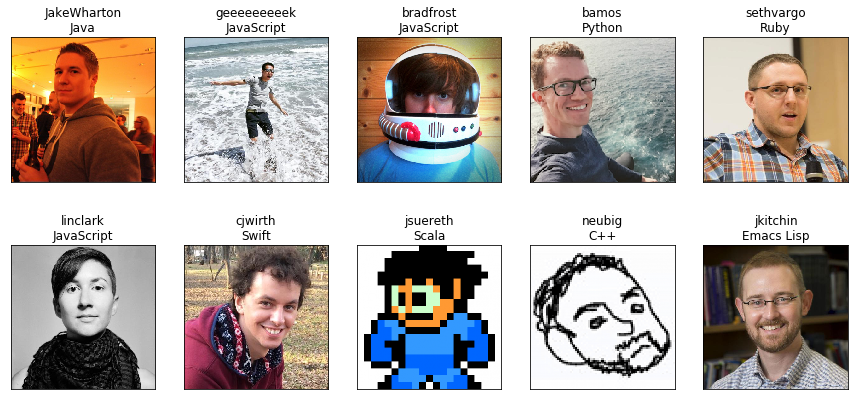

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from PIL import Image
import requests
from skimage import io

pos_list = list(range(1, 1 + len(pitts_users_frame)))
url_list = pitts_users_frame['avatar_url']
uname_list = pitts_users_frame['username']
lang_list = pitts_users_frame['language']

plt.figure(figsize = (15, 7))

for pos, url, uname, lang in zip(pos_list, url_list, uname_list, lang_list):
    plt.subplot(2, 5, pos)
    im = io.imread(url)
    plt.imshow(im)
    plt.xticks([])
    plt.yticks([])
    plt.title('{}\n{}'.format(uname, lang))

plt.show()

#### Analysis
The hottest user in Pittsburgh is JakeWharton! Pittsburgh seems to be a coder paradise with user actively commited to Github. Do you know any of the top coders?

# A Deeper Look: Recommending Collaborators
In addtion to the above interesting statistics of Github, is there more we can do use the data on Github?
The answer is absolutely YES! Now we would like to introduce you to our collaborator recommender system.
## Motivation
When someone starts a new repo or wanna conitnue growing the existing one, a very important thing is to get more collaborators to commit to the repo. We could scarpe data of user's commit number to repos, and then trying to recommend collaborators to a specific repo.

The basic idea is very simple. Our recommender is built on the information of 1000 users with most followers and whose preference language is JavaScript. The repos are all the repositories commited by these users. Like the user-movie problem, we built the recommender system using collaborative filetering with matrix factorization. We built a repo-user matrix and try to predict the user's potential commit to a repostitory. Then try to recommend users with most potential commits to one repository.
## Data Collecting and Processing
We use Google BigQuery to access all the commit information of one user in the recent year. A simple example is showed to illustrate how to access all the commits built by user JakeWharton. For further referece, you could check the documentation  for [setting up BigQuery service](https://cloud.google.com/bigquery/create-simple-app-api#bigquery-simple-app-download-python) and [create service](https://cloud.google.com/docs/authentication/getting-started).

In [2]:
import numpy as np
import scipy.sparse as sp
import scipy.linalg as la
import matplotlib
import os, sys
import matplotlib.pyplot as plt
from google.cloud import bigquery
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'bigquery-key.json'

In [3]:
client = bigquery.Client()

def get_repos_count(author_name):
    sql = ("""
SELECT
  repo_name
FROM
  `bigquery-public-data.github_repos.commits`
WHERE
  author.name = '{}'
""".format(author_name))
    

    query_job = client.query(sql)
    results = [x.repo_name[0] for x in query_job.result()]
    results = Counter(results)
    ret = {}
    for k,v in results.items():
        repo_name = k.split('/')[1]
        ret[repo_name] = v
    return ret

ret = get_repos_count('JakeWharton')
print(ret)

{'dominate': 245, 'flownbird': 1, 'WebHubBot': 2, 'pycache': 3, 'SMSBarrage': 2, 'is_awesome': 63, 'mkvdts2ac3': 54, 'trakt-java': 3, 'ActionBarSherlock': 36, 'py-videodownloader': 51, 'com.lowereast.guiceymongo': 11, 'github-deploy-maven-plugin': 14, 'maven-android-sdk-deployer': 1}


The above result shows the repo JakeWharton commits to and the number of commit he makes. The detailed data collection code is appended in the [Appendix](#Collect-data-from-Google-BigQuery-to-build-recommender-system
). The collected data is saved in "topJSuser_commits.json"
Then the data is processed and saved in to 'commits.csv' file with column 'repo','author','num'. The repo-user matrix with known commit number and zeros for unknown commit is built on top of the csv file. The detail data processing is attached in the [Appendix](#Process-data-to-build-recommender-system) as well. 

## Building the Recommender

Here we import the recommender system code in homework 4 as modified_collaborative_filtering.py. Then we train the recommender with k = 5. We split the data into training set and testing set. The training error and testing mean square error is showed in the plot

In [53]:
import modified_collaborative_filtering as cf

In [56]:
X_tr, X_te, a2i_mp, r2i_mp, i2a_mp, i2r_mp = process(commits_pd, np.random.permutation(len(commits_pd)))
k = 5
m, n = X_tr.shape

U = np.random.random((m, k))
V = np.random.random((n, k))

retU, retV, tr_error, te_error = cf.train(X_tr, X_te, k, U, V, verbose= True)

In [55]:
scatter_x = list(range(len(tr_error)))

trace0 = go.Scatter(
    x = scatter_x,
    y = tr_error,
    mode = 'lines',
    name = 'test error'
)
trace1 = go.Scatter(
    x = scatter_x,
    y = te_error,
    mode = 'lines',
    name = 'train error'
)

py.iplot([trace0, trace1], filename='recommender_error_plot')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~io07tree/0 or inside your plot.ly account where it is named 'recommender_error_plot'


We then save the trained feature matrix into file for later recommendation, see [Appendix](#Save-the-trained-feature-matrix-into-file).

## Recommendation Result
Now we are going to use the trained UV matrix to receommend possible collaborators to a repo.
We take the popular 'vue' repository as an example, it recommends 5 users with highest number of potential commit to the repository.

In [22]:
def _recommend(X, r2i_mp, i2a_mp, repo_name, cap):
    cap = min(cap, X.shape[1])
    repo_idx = r2i_mp[repo_name]
    idxs = np.argsort(X[repo_idx])[-cap:].tolist()
    
    ret = [i2a_mp[x] for x in idxs]
    
    return ret

In [23]:
X = np.load(UV_MATRIX_PATH)
recommend_authors = _recommend(X_prd, r2i_mp, i2a_mp, 'vue', 5)
print(recommend_authors)

['azu', 'photonstorm', 'unconed', 'leo', 'gorhill']


# References

Some references are listed below for your interest.

- [Github API official documentation](https://developer.github.com/v3/)
- [Github opendata on Google BigQuery](https://cloud.google.com/bigquery/public-data/github)
- [Google BigQuery documentaiton](https://cloud.google.com/bigquery/docs/)
- [Github Search API](https://developer.github.com/v3/search/)
- [Google Geocoding API](https://developers.google.com/maps/documentation/geocoding/start)
- [Visualization library: Plotly](https://plot.ly/)
- [Video making tool:](https://www.videoscribe.co/en/)
- [Collaborative filtering](http://www.datasciencecourse.org/notes/recommender/)

And here is a [link](https://www.youtube.com/watch?v=ZqcFxnjq7HY) to the intro video of our project, have fun!

# Appendix

## Collect hot repositories data

In [0]:
search_groups = [(1000,20),(1500,50),(8500,100)]
search_range = []
#from 500 - 1000 every 20
#from 1000-1500 every 50
#from 1500 - 8500 every 100
i = 500
for j in range(len(search_groups)):
    while(i < search_groups[j][0]):
        gap = search_groups[j][1]
        search_range.append((i+1,i+gap))
        i+=gap

In [0]:
from requests.auth import HTTPBasicAuth
import time
import json

auth = HTTPBasicAuth(GITHUB_USER_NAME, GITHUB_USER_PASSWORD)
#search for repos in a specific range, enumerate page number
#dump data to json file
#input: query_term header authentication info, and current founded items
#output: udpate total founded items
def search_in_range(query,headers,auth,order):
    json_file = requests.get(query, headers = headers, auth = auth).json()
    try:
        total_result_num = json_file['total_count']
    except:
        #print(json_file)
        return order
    
    page_num = int(total_result_num % 100) + 1
    for i in range(page_num):
        q = query + ('&page={}&per_page=100'.format(i+1))
        r = requests.get(q,headers = headers, auth = auth)
        data = r.json()
        try :
            #print(len(data['items']))
            if(len(data['items']) == 0):
                return order+i
            else:
                with open('users/crawl_data{}.json'.format(order+i), 'w') as f:
                    json.dump(data, f)
        except:
            continue
        time.sleep(10)             
    
    return order+page_num

#scarpe repositories who has more than 500 stars
#from 501 - 8500 search in customed range
base_repo_search = 'https://api.github.com/search/repositories?o=desc&s=stars&fork=false'
order = 425
for i in range(5,len(search_range)):
    print("range: {}- {}".format(search_range[i][0],search_range[i][1]))
    query = base_repo_search + '&q=stars%3A{}..{}'.format(search_range[i][0],search_range[i][1])
    order = search_in_range(query,headers,auth,order)
    time.sleep(5)

#more than 8500 stars
query = base_repo_search +  '&q=stars%3A>%3D8500'
search_in_range(query,headers,auth,order)

## Collect top users data

In [17]:
search_groups = [(150,2),(200,5),(300,10),(600,30),(1500,200)]
search_range = []

#from 100 - 150 every 2
#from 150 - 200 every 5
#from 200 - 300 every 10
#from 300 - 600 every 30
#from 600-1500 every 200
i = 100
for j in range(len(search_groups)):
    while(i < search_groups[j][0]):
        gap = search_groups[j][1]
        search_range.append((i+1,i+gap))
        i+=gap

def search_in_range_user(query,auth,order):
    i = 1
    while True:
        params = {'start_page': i}
        r = requests.get(query,headers = headers, params= params, auth = auth)
        data = r.json()
        try :
            print(len(data['users']))
            if(len(data['users']) == 0):
                return order+i
            else:
                with open('users_l/crawl_data{}.json'.format(order+i), 'w') as f:
                    json.dump(data, f)
        except:
            return order+i
        i+=1
        time.sleep(10)             
    
    return order+page_num

order = 0
base_user_search = 'https://api.github.com/legacy/user/search/'
for i in range(len(search_range)):
    print("range: {}- {}".format(search_range[i][0],search_range[i][1]))
    query = base_user_search + 'followers%3A{}..{}'.format(search_range[i][0],search_range[i][1])
    order = search_in_range_user(query,auth,order)
    time.sleep(5)

query = base_user_search + 'followers%3A>%3D1600'
search_in_range_user(query,auth,order)

## Get user's country info from geoencoding

In [ ]:
import googlemaps
from datetime import datetime

gmaps = googlemaps.Client(key=GOOGLE_MAP_API_KEY)

def _country_name(region_address):
    try:
        _result = gmaps.geocode(region_address)
    except:
        return None
    if len(_result) > 0:
        components_list = _result[0]['address_components']
        for e in components_list:
            if 'country' in e['types']:
                return (e['long_name'], e['short_name'])
    else:
        return None
    
import time
total = 0
for i in range(len(user_info_dict['location'])):
    location = user_info_dict['location'][i]
    country = _country_name(location)
    total+=1
    if total % 45 == 44:
        print(len(countries_new))
        time.sleep(1)
    if country is not None:
        countries_new.append(country[0])
        
with open('countries.json', 'w') as outfile:
    json.dump(countries_new,outfile)

## Collect data from Google BigQuery to build recommender system

In [58]:
COMMIT_PATH = "topJSuser_commits.json"
SAVE_PERIOD = 50

def get_commit_mp(author_list):
    
    numberOfauthors = len(author_list)
    print(numberOfauthors, author_list[:10])
    
    ret = {}
    
    def dump_dict():
        with open(COMMIT_PATH, 'w') as f:
            json_str = json.dumps(ret)
            f.write(json_str)
    
    for username in author_list:
        repo_count = get_repos_count(username)
        ret[username] = repo_count
        if not len(ret) % SAVE_PERIOD:
            print(len(ret), repo_count)
            dump_dict()
        time.sleep(1)
    
    dump_dict()

    return ret

In [ ]:
# collect repos number for top 1000 javascript contributor, saved in .json format

AUTHOR_PATH = "topJSuser.json"

with open(AUTHOR_PATH, 'r') as f:
    json_str = f.readline()
    author_list = json.loads(json_str)

# (key, value) : (author_name, {repo_name, commit_number})
commit_mp = get_commit_mp(author_list)
print(commit_mp)

## Process data to build recommender system

In [49]:
import csv

In [50]:
COMMIT_CSV_PATH = "commits.csv"
with open(COMMIT_PATH, 'r') as f:
    json_str = f.readline()

mp = json.loads(json_str)
data= [('repo','author','num')]

for author in mp:
    a_mp = mp[author]
    for repo in a_mp:
        data.append((repo, author, a_mp[repo]))

with open(COMMIT_CSV_PATH, 'w') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerows(data)

In [51]:
commits_pd = pd.read_csv(COMMIT_CSV_PATH)
commits_pd.columns
commits_pd['num'] = commits_pd['num'].astype('float64')
commits_pd.dtypes

repo       object
author     object
num       float64
dtype: object

In [52]:
##build repo-user matrix
import math
def process(commits, P):
    authorToidx_mp = {}
    repoToidx_mp = {}
    idxToauthor_mp = {}
    idxTorepo_mp = {}
    
    authors = commits['author'].unique()
    repos = commits['repo'].unique()
    
    numberOfAuthor = len(authors)
    numberOfRepo = len(repos)
    numberOfCommit = len(commits)
    
    for i in range(numberOfAuthor):
        authorToidx_mp[authors[i]] = i
        idxToauthor_mp[i] = authors[i]
    
    for i in range(numberOfRepo):
        repoToidx_mp[repos[i]] = i
        idxTorepo_mp[i] = repos[i]
    
    X_tr = np.zeros((numberOfRepo, numberOfAuthor))
    X_te = np.zeros((numberOfRepo, numberOfAuthor))
    
    threshold = int(math.floor(numberOfCommit * 0.9))
    
    for idx, row in commits.iterrows():
        a_id = authorToidx_mp[row['author']]
        r_id = repoToidx_mp[row['repo']]
        val = row['num']
        
        if idx < threshold:
            X_tr[r_id][a_id] = val
        else:
            X_te[r_id][a_id] = val
    
    return X_tr, X_te, authorToidx_mp, repoToidx_mp, idxToauthor_mp, idxTorepo_mp

## Save the trained feature matrix into file

In [20]:
#save UV matrix
def create_UV_matrix(X, U, V):
    import copy
    
    uv_matrix = U @ V.T
    
    X_copy = copy.deepcopy(X)
    
    X_copy[X!=0] = -1.0
    X_copy[X==0] = uv_matrix[X==0]
    
    return X_copy

UV_MATRIX_PATH = "uv_matrix.npy"

X_prd = create_UV_matrix(X_tr, retU, retV)
np.save(UV_MATRIX_PATH, X_prd)